# Multi-Label Text Classification Using Bidirectional LSTM (RNN)

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv
Saving train_label.csv to train_label.csv


## [1] Loading data

In [0]:
import numpy as np
import pandas as pd

train = pd.read_csv("train_data.csv")
label = pd.read_csv("train_label.csv")
test = pd.read_csv("test_data.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [4]:
print(train.shape) 
print(label.shape) 
print(test.shape)
print(sample_submission.shape)

(41569, 2)
(75170, 2)
(10393, 2)
(10393, 16)


## [2] Data Preparation

In [5]:
from sklearn import preprocessing

lb = preprocessing.LabelBinarizer()
lb.fit(label['label'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [6]:
lb.classes_

array(['Assembly Required', 'Color', 'Commercial / Residential',
       'ENERGY STAR Certified', 'Features', 'Finish',
       'Flooring Product Type', 'Hardware Included', 'Included',
       'Indoor/Outdoor', 'Package Quantity', 'Shape',
       'Tools Product Type', 'Voltage (volts)', 'Wattage (watts)'],
      dtype='<U24')

In [0]:
a = lb.transform(label['label'])

In [0]:
classes = pd.DataFrame(a, columns=['Assembly Required', 'Color', 'Commercial / Residential',
       'ENERGY STAR Certified', 'Features', 'Finish',
       'Flooring Product Type', 'Hardware Included', 'Included',
       'Indoor/Outdoor', 'Package Quantity', 'Shape',
       'Tools Product Type', 'Voltage (volts)', 'Wattage (watts)'])  

In [10]:
result = pd.concat([label, classes], axis=1)
result.head()

,id,label,Assembly Required,Color,Commercial / Residential,ENERGY STAR Certified,Features,Finish,Flooring Product Type,Hardware Included,Included,Indoor/Outdoor,Package Quantity,Shape,Tools Product Type,Voltage (volts),Wattage (watts)
0,100003,Shape,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,100004,Voltage (volts),0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,100004,Wattage (watts),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,100006,Wattage (watts),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,100007,ENERGY STAR Certified,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [0]:
res = result.drop(['label'], axis=1)

In [0]:
df = pd.merge(train, res, on=['id'])

## [3] Text in each category

In [86]:
df_label = df.drop(['id', 'text'], axis=1)
counts = []
categories = list(df_label.columns.values)
for i in categories:
    counts.append((i, df_label[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,Assembly Required,4266
1,Color,4505
2,Commercial / Residential,6866
3,ENERGY STAR Certified,6509
4,Features,3821
5,Finish,3602
6,Flooring Product Type,4422
7,Hardware Included,5471
8,Included,4465
9,Indoor/Outdoor,9420


Text(0.5, 0, 'category')

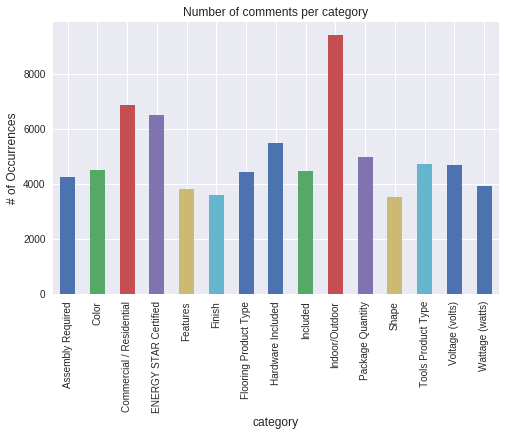

In [87]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

## [4] Text Preprocessing

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
  


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [38]:
from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 75170/75170 [00:39<00:00, 1919.04it/s]


In [0]:
df['CleanedText']=preprocessed_reviews

## [5] Model

In [0]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
list_sentences_train = df["CleanedText"].values
list_classes = ['Assembly Required', 'Color', 'Commercial / Residential',
       'ENERGY STAR Certified', 'Features', 'Finish',
       'Flooring Product Type', 'Hardware Included', 'Included',
       'Indoor/Outdoor', 'Package Quantity', 'Shape',
       'Tools Product Type', 'Voltage (volts)', 'Wattage (watts)']
y = df[list_classes].values
list_sentences_test = test["text"].values

In [0]:
#Standard keras preprocessing, 
#to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

max_features = 20000

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_train = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

In [47]:
#Simple bidirectional LSTM with two fully connected layers. 
#adding some dropout to the LSTM since even 2 epochs is enough to overfit.

maxlen = 100
embed_size = 128
batch_size = 32
epochs = 2
  
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(LSTM(50, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(15, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 100)          71600     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 100)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
__________

In [48]:
# Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Fitting the data to the model
history = model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.3) 

Train on 52619 samples, validate on 22551 samples
Epoch 1/2
52619/52619 [==============================] - 449s 9ms/step - loss: 0.2048 - acc: 0.9309 - val_loss: 0.1526 - val_acc: 0.9385
Epoch 2/2
52619/52619 [==============================] - 445s 8ms/step - loss: 0.1452 - acc: 0.9389 - val_loss: 0.1313 - val_acc: 0.9430


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import time
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error

def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid(True)
    fig.canvas.draw()

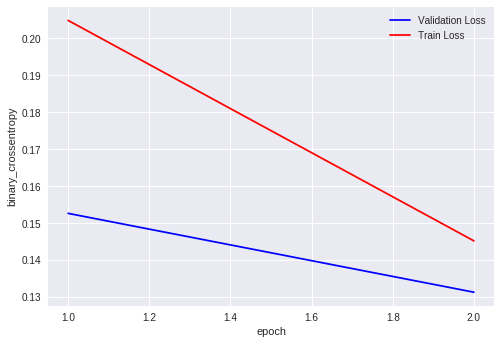

In [50]:
# Validation plot
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('binary_crossentropy')

# list of epoch numbers
x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [52]:
y_test = model.predict([X_test], batch_size=1024, verbose=1)
sample_submission = pd.read_csv(f'sample_submission.csv')
sample_submission[list_classes] = y_test
sample_submission.to_csv('submission.csv', index=False)

10393/10393 [==============================] - 13s 1ms/step


In [53]:
b = pd.read_csv('submission.csv')
b.head()

,id,Indoor/Outdoor,Commercial / Residential,ENERGY STAR Certified,Hardware Included,Package Quantity,Flooring Product Type,Color,Tools Product Type,Included,Voltage (volts),Assembly Required,Features,Wattage (watts),Finish,Shape
0,114689,0.203735,0.001157,0.001561,0.000971,0.707016,0.000266,0.004056,0.000632,0.000185,0.000617,0.000003,0.000021,0.000139,0.067346,0.000333
1,183172,0.002523,0.001735,0.001392,0.000128,0.001788,0.000316,0.000690,0.605530,0.012217,0.395058,0.002785,0.000006,0.001529,0.000004,0.000577
2,217304,0.026385,0.000549,0.002213,0.011359,0.825187,0.000073,0.029446,0.010561,0.001444,0.004343,0.000548,0.000026,0.000590,0.074570,0.003728
3,184115,0.331808,0.369900,0.000372,0.000119,0.001166,0.288054,0.015582,0.000351,0.000176,0.000280,0.000067,0.004260,0.000044,0.000365,0.001639
4,103786,0.071457,0.065183,0.001432,0.029298,0.016845,0.006179,0.585410,0.000878,0.001987,0.005792,0.082526,0.010660,0.001053,0.027094,0.026749


In [0]:
from google.colab import files
files.download('submission.csv')